## Certificate Chain Validation

In [1]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract

### Readin zeek logs

In [2]:
zeek = pd.read_csv("../datasets/ny_zeek_sslx509.csv")

In [3]:
zeek.shape

(6180, 47)

In [4]:
zeek['validation_status'].value_counts().nlargest(10)

ok                                              5577
unable to get local issuer certificate           337
self signed certificate in certificate chain     246
certificate has expired                           10
self signed certificate                           10
Name: validation_status, dtype: int64

In [5]:
zeek.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days
541,1.650125e+09,CrHoi8YJ4NOpzLaii,67.205.150.252,47056.0,54.227.72.118,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,account-public-service-prod.ol.epicgames.com,F,-,-,T,CsxknGIti,"709107b6f75470665afbe943857cf0cc717c6ee0e11b750d50816bf6dc245ba1,f55f9ffcb83c73453261601c7e044db15a0f034b93c05830f28635ef889cf670,87dcd4dc74640a322cd205552506d1be64f12596258096544986b4850bc72706,2...",(empty),T,ok,709107b6f75470665afbe943857cf0cc717c6ee0e11b750d50816bf6dc245ba1,1.650125e+09,3.0,0350473B73D49491D9DBED36282E846C,CN=*.ol.epicgames.com,"CN=Amazon,OU=Server CA 1B,O=Amazon,C=US",1.644124e+09,1.678165e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,*.ol.epicgames.com,-,-,-,F,-,T,F,Amazon,Amazon,*.ol.epicgames.com,"02/06/2022, 00:00:00","03/06/2023, 23:59:59",393


In [6]:
zeek.loc[zeek['validation_status'] == "ok"]['issuer_O'].value_counts()

DigiCert Inc                 2112
Amazon                       1709
Google Trust Services LLC     807
GoDaddy.com\\                 204
Sectigo Limited               160
Microsoft Corporation         120
Apple Inc.                    117
Let's Encrypt                  83
GlobalSign nv-sa               73
Cloudflare\\                   54
COMODO CA Limited              48
Entrust\\                      38
Network Solutions L.L.C.       28
ZeroSSL                        12
Comodo Japan\\                  8
TAIWAN-CA                       2
Trustwave Holdings\\            1
Gandi                           1
Name: issuer_O, dtype: int64

In [7]:
zeek.drop_duplicates(['issuer_CN', 'certificate.serial']).shape

(842, 47)

In [8]:
zeek.loc[(zeek['validation_status'] == "unable to get local issuer certificate") |\
         (zeek['validation_status'] == "certificate has expired")]['server_name'].value_counts().shape

(59,)

In [9]:
zeek.loc[(zeek['validation_status'] != "ok") &\
         (zeek['validation_status'] != "certificate has expired")].drop_duplicates(['issuer_CN', 'certificate.serial']).shape

(83, 47)

In [10]:
zeek.loc[zeek['validation_status'] == "unable to get local issuer certificate"]['issuer_O'].value_counts()

Netflix\\                           91
Roku\\                              87
Samsung Electronics                 47
Microsoft Corporation               40
Nintendo of America Inc.            20
Symantec Corporation                19
Nest Labs\\                         14
CN=Tesla Motors DAS Services CA      6
Sony Computer Entertainment Inc.     4
CN=Tesla Motors Services CA          3
Tesla Inc.                           3
Apple Inc.                           1
Philips Hue                          1
Obihai Technology Inc.               1
Name: issuer_O, dtype: int64

In [11]:
zeek.loc[(zeek['validation_status'] == "unable to get local issuer certificate") &\
         (~zeek['issuer_O'].str.contains("Microsoft")) &\
         (~zeek['issuer_O'].str.contains("Symantec")) &\
         (~zeek['issuer_O'].str.contains("Apple"))].drop_duplicates(['issuer_CN', 'certificate.serial']).shape

(38, 47)

In [12]:
zeek.loc[(zeek['validation_status'] != "ok") &\
         (zeek['validation_status'] != "certificate has expired")]['server_name'].value_counts().shape

(117,)

### Merge on SNIs to obtain device info

In [13]:
dev_name = pd.read_parquet("../datasets/sni_used_to_generate_pcaps.parquet")

In [14]:
dev_name.sample(1)

,device_id,sni,device_vendor,device_name,user_key
16588,s22f8a8147d,lh4.ggpht.com,google,chromecast,sMTaCHtdFL9bL75b


In [15]:
zeek_merge = pd.merge(zeek, dev_name, left_on='server_name', right_on='sni', how='inner')\
               .drop(columns=['user_key'])

In [16]:
zeek_merge.shape

(126754, 51)

In [17]:
zeek_merge['device_id'].value_counts().shape

(2014,)

In [18]:
pd.set_option('display.max_colwidth', None)

In [19]:
zeek_merge['domain'] = zeek_merge['server_name'].apply(lambda x: "{}.{}"\
                                                .format(tldextract.extract(x).domain, tldextract.extract(x).suffix))

In [20]:
zeek_merge['chain_len'] = zeek_merge['cert_chain_fps'].apply(lambda x: len(x.split(",")))

In [21]:
zeek_merge.loc[(zeek_merge['validation_status'] != "ok") &\
               (zeek_merge['validation_status'] != "-")]['server_name'].value_counts().shape

(121,)

### unable to get local issuer certificate

In [22]:
unable = zeek_merge.loc[zeek_merge['validation_status'] == "unable to get local issuer certificate"]

In [23]:
unable.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len
26189,1.650132e+09,CCN8qZ3huNU65Sr5D3,67.205.150.252,52033.0,3.224.67.251,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,ichnaea.netflix.com,F,-,-,T,CsxknGIi,"59cd62fab23bd9eeb334684d575a3f816f39f376656dba19ef5f4335b8d234eb,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,59cd62fab23bd9eeb334684d575a3f816f39f376656dba19ef5f4335b8d234eb,1.650132e+09,3.0,0A3221A7EBF99D71960D31FE425AB69D,"CN=customerevents.netflix.com,O=Netflix\\, Inc.,L=Los Gatos,ST=California,C=US","CN=Netflix Public SHA2 RSA CA 3,O=Netflix\\, Inc.,C=US",1.643260e+09,1.677560e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"ichnaea.netflix.com,beacon.netflix.com,presentationtracking.netflix.com,nmtracking.netflix.com,customerevents.netflix.com",-,-,-,F,-,T,F,Netflix\\,Netflix Public SHA2 RSA CA 3,customerevents.netflix.com,"01/27/2022, 00:00:00","02/27/2023, 23:59:59",396,s34a561843b,ichnaea.netflix.com,samsung,unnud,netflix.com,2


In [24]:
unable_domain = unable.groupby('domain')['server_name'].agg(fqdn_set=lambda x: sorted(set(x)), fqdn_num=lambda x: len(set(x))).reset_index()

In [25]:
unable_vendor = unable.groupby('domain')['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [26]:
unable_chainlen = unable.groupby('domain')['chain_len'].agg(chain_len_set=lambda x: set(x)).reset_index()

In [27]:
unable_issuer = unable.groupby('domain')['issuer_O'].agg(issuer_set=lambda x: sorted(set(x))).reset_index()

In [28]:
unable_devnum = unable.groupby('domain')['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [29]:
unable_gb = pd.merge(unable_domain, unable_vendor, left_on='domain', right_on='domain', how='inner')

In [30]:
unable_gb = pd.merge(unable_gb, unable_chainlen, left_on='domain', right_on='domain', how='inner')

In [31]:
unable_gb = pd.merge(unable_gb, unable_issuer, left_on='domain', right_on='domain', how='inner')

In [32]:
unable_gb = pd.merge(unable_gb, unable_devnum, left_on='domain', right_on='domain', how='inner')

In [33]:
unable_gb.shape

(15, 7)

In [34]:
unable_gb.sort_values(by='fqdn_num', ascending=False).sort_values(by='devnum', ascending=False)[:15]

,domain,fqdn_set,fqdn_num,vendor_set,chain_len_set,issuer_set,devnum
5,netflix.com,"[api-global.netflix.com, api.netflix.com, customerevents.netflix.com, ichnaea.netflix.com, secure.netflix.com, uiboot.netflix.com]",6,"[amazon, amcrest, brother, dish network, hp, humax, insignia, lg, nvidia, panasonic, philips, roku, samsung, sharp, sky, sony, tcl, tivo, vizio, wink, xiaomi]",{2},[Netflix\\],278
9,roku.com,"[amarillo.sw.roku.com, api.roku.com, api.sr.roku.com, austin.logs.roku.com, austin.sw.roku.com, bryan.sw.roku.com, cooper.logs.roku.com, giga.logs.roku.com, giga.sw.roku.com, gilbert.sw.roku.com, liberty.logs.roku.com, liberty.sw.roku.com, longview.sw.roku.com, scribe.logs.roku.com, sugarland.sw.roku.com]",15,"[brother, cisco, insignia, roku, sharp, tcl]","{1, 2, 3}",[Roku\\],131
4,nest.com,"[frontdoor.nest.com, logsink.devices.nest.com, weather.nest.com]",3,"[google, philips, synology]",{2},[Nest Labs\\],65
11,samsungcloudsolution.net,"[configprd.samsungcloudsolution.net, lcprd1.samsungcloudsolution.net, lcstg1.samsungcloudsolution.net, otnprd10.samsungcloudsolution.net, otnprd11.samsungcloudsolution.net, otnprd8.samsungcloudsolution.net, otnprd9.samsungcloudsolution.net]",7,"[netatmo, samsung]",{1},[Samsung Electronics],43
2,meethue.com,[ws.meethue.com],1,[philips],{2},[Philips Hue],31
6,nintendo.net,"[dauth-lp1.ndas.srv.nintendo.net, receive-lp1.dg.srv.nintendo.net, receive-lp1.er.srv.nintendo.net, storage.lp1.scsi.srv.nintendo.net]",4,[nintendo],{1},[Nintendo of America Inc.],24
10,samsungcloudsolution.com,"[acr0.samsungcloudsolution.com, fkp.samsungcloudsolution.com, sas.samsungcloudsolution.com, time.samsungcloudsolution.com]",4,"[netatmo, samsung]",{1},[Samsung Electronics],24
8,playstation.net,[event.api.np.km.playstation.net],1,[sony],{1},[Sony Computer Entertainment Inc.],13
13,sonyentertainmentnetwork.com,[hh.prod.sonyentertainmentnetwork.com],1,[sony],{1},[Sony Computer Entertainment Inc.],9
3,microsoft.com,"[geo-prod.do.dsp.mp.microsoft.com, settings-win.data.microsoft.com, tsfe.trafficshaping.dsp.mp.microsoft.com, v10.events.data.microsoft.com, watson.telemetry.microsoft.com]",5,"[hp, lutron, xiaomi]",{2},[Microsoft Corporation],6


### self signed certificate in certificate chain

In [35]:
self_in_chain = zeek_merge.loc[zeek_merge['validation_status'] == "self signed certificate in certificate chain"]

In [36]:
self_in_chain_domain = self_in_chain.groupby('domain')['server_name'].agg(fqdn_set=lambda x: sorted(set(x)), \
                                                                          fqdn_num=lambda x: len(set(x))).reset_index()

In [37]:
self_in_chain_vendor = self_in_chain.groupby('domain')['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [38]:
self_in_chain_chainlen = self_in_chain.groupby('domain')['chain_len'].agg(chain_len_set=lambda x: set(x)).reset_index()

In [39]:
self_in_chain_issuer = self_in_chain.groupby('domain')['issuer_O'].agg(chain_len_set=lambda x: sorted(set(x))).reset_index()

In [40]:
self_in_chain_devnum = self_in_chain.groupby('domain')['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [41]:
self_in_chain_gb = pd.merge(self_in_chain_domain, self_in_chain_vendor, left_on='domain', right_on='domain', how='inner')

In [42]:
self_in_chain_gb = pd.merge(self_in_chain_gb, self_in_chain_chainlen, left_on='domain', right_on='domain', how='inner')

In [43]:
self_in_chain_gb = pd.merge(self_in_chain_gb, self_in_chain_issuer, left_on='domain', right_on='domain', how='inner')

In [44]:
self_in_chain_gb = pd.merge(self_in_chain_gb, self_in_chain_devnum, left_on='domain', right_on='domain', how='inner')

In [45]:
self_in_chain_gb.shape

(16, 7)

In [46]:
self_in_chain_gb.sort_values(by='fqdn_num', ascending=False).sort_values(by='devnum', ascending=False)[:20]

,domain,fqdn_set,fqdn_num,vendor_set,chain_len_set_x,chain_len_set_y,devnum
10,roku.com,"[amarillo.sb.roku.com, api2.sr.roku.com, austin.sb.roku.com, bryan.sb.roku.com, cloudservices.roku.com, configsvc.cs.roku.com, content.sr.roku.com, cooper.sb.roku.com, giga.sb.roku.com, gilbert.sb.roku.com, i.ads.roku.com, liberty.sb.roku.com, longview.sb.roku.com, sugarland.sb.roku.com, tis.cti.roku.com]",15,"[brother, cisco, insignia, roku, sharp, tcl]","{2, 3}",[Roku\\],102
11,rokutime.com,[api.rokutime.com],1,"[brother, insignia, roku, tcl]",{2},[Roku\\],38
7,nintendo.net,"[aauth-lp1.ndas.srv.nintendo.net, app-a03.lp1.npns.srv.nintendo.net, app-a04.lp1.npns.srv.nintendo.net, app.lp1.five.nintendo.net, aqua.hac.lp1.d4c.nintendo.net, bcat-data-lp1.cdn.nintendo.net, bcat-list-lp1.cdn.nintendo.net, bcat-topics-lp1.cdn.nintendo.net, broker.lp1.npns.srv.nintendo.net, capi.lp1.op2.nintendo.net, dragons.hac.lp1.dragons.nintendo.net, nppl.app.nintendo.net, sun.hac.lp1.d4c.nintendo.net, tagaya.hac.lp1.eshop.nintendo.net]",14,[nintendo],{2},"[Nintendo of America Inc., Nintendo of America\\]",28
9,playstation.net,"[auth.api.np.ac.playstation.net, checkout.rnps.dl.playstation.net, friends.rnps.dl.playstation.net, fus01.ps4.update.playstation.net, gs-sec.ww.np.dl.playstation.net, party.rnps.dl.playstation.net, ps4updptl.us.np.community.playstation.net, resource.np.ac.playstation.net, rnps-crl.dl.playstation.net, trophy.ww.np.community.playstation.net, us-push.np.communication.playstation.net]",11,[sony],{2},[Sony Computer Entertainment Inc.],17
5,netflix.com,"[appboot.netflix.com, nrdp.nccp.netflix.com, nrdp50-appboot.netflix.com, nrdp51-appboot.netflix.com]",4,"[amazon, lg, panasonic, roku, samsung, sony, tivo]",{2},[Netflix Inc],15
4,lgtvsdp.com,"[ca.rdx2.lgtvsdp.com, us.rdx2.lgtvsdp.com]",2,[lg],{2},[LG Electronics Inc.],12
1,canaryis.com,"[b.canaryis.com, i.canaryis.com]",2,[canary],{4},[Canary Connect\\],10
6,netflix.net,[nccp-nrdp-31.cloud.netflix.net],1,"[roku, samsung]",{2},[Netflix Inc],9
12,samsungelectronics.com,[bpu.samsungelectronics.com],1,[samsung],{4},[Samsung Electronics],8
8,pavv.co.kr,[infolink.pavv.co.kr],1,"[netatmo, samsung]",{2},[Samsung Electronics],7


### self signed certificate

In [47]:
self_signed = zeek_merge.loc[zeek_merge['validation_status'] == "self signed certificate"]

In [48]:
self_signed_domain = self_signed.groupby('domain')['server_name'].agg(fqdn_set=lambda x: sorted(set(x)), \
                                                                      fqdn_num=lambda x: len(set(x))).reset_index()

In [49]:
self_signed_vendor = self_signed.groupby('domain')['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [50]:
self_signed_chainlen = self_signed.groupby('domain')['chain_len'].agg(chain_len_set=lambda x: set(x)).reset_index()

In [51]:
self_signed_issuer = self_signed.groupby('domain')['issuer_O'].agg(chain_len_set=lambda x: set(x)).reset_index()

In [52]:
self_signed_devnum = self_signed.groupby('domain')['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [53]:
self_signed_gb = pd.merge(self_signed_domain, self_signed_vendor, left_on='domain', right_on='domain', how='inner')

In [54]:
self_signed_gb = pd.merge(self_signed_gb, self_signed_chainlen, left_on='domain', right_on='domain', how='inner')

In [55]:
self_signed_gb = pd.merge(self_signed_gb, self_signed_issuer, left_on='domain', right_on='domain', how='inner')

In [56]:
self_signed_gb = pd.merge(self_signed_gb, self_signed_devnum, left_on='domain', right_on='domain', how='inner')

In [57]:
self_signed_gb.shape

(4, 7)

In [58]:
self_signed_gb.sort_values(by='fqdn_num', ascending=False).sort_values(by='devnum', ascending=False)[:15]

,domain,fqdn_set,fqdn_num,vendor_set,chain_len_set_x,chain_len_set_y,devnum
3,ueiwsp.com,[selfsigned.ueiwsp.com],1,[samsung],{1},{Universal Electronics Inc},8
0,dishaccess.tv,[vmeasureul.dishaccess.tv],1,[dish network],{1},{EchoStar},3
1,samsunghrm.com,[log.samsunghrm.com],1,[samsung],{2},{Samsung\\},3
2,tuyaus.com,[a2.tuyaus.com],1,[tuya],{1},{Tuya Global Inc.},3


In [59]:
zeek_merge.loc[zeek_merge['server_name'].str.endswith('ueiwsp.com')]['chain_len']

61678    1
61679    1
61680    1
61681    1
61682    1
61683    1
61684    1
61685    1
61686    1
61687    1
61688    1
61689    1
61690    1
61691    1
61692    1
61693    1
Name: chain_len, dtype: int64

In [60]:
self_signed.loc[self_signed['server_name'] == "log.samsunghrm.com"]

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len
69021,1.650131e+09,CgU5U43miot7Xf81Mj,67.205.150.252,53674.0,52.192.208.223,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,log.samsunghrm.com,F,-,-,T,CsxknGIti,"e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e",(empty),T,self signed certificate,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,1.650131e+09,3.0,D5D3DFC69D30EFC6,"CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com","CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com",1.533708e+09,2.479788e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.samsunghrm.com,localhost,127.0.0.1",-,-,-,-,-,T,F,Samsung\\,*.samsunghrm.com,*.samsunghrm.com,"08/08/2018, 02:06:36","07/31/2048, 02:06:36",10950,s4487de9e7d,log.samsunghrm.com,samsung,fridge,samsunghrm.com,2
69022,1.650131e+09,CgU5U43miot7Xf81Mj,67.205.150.252,53674.0,52.192.208.223,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,log.samsunghrm.com,F,-,-,T,CsxknGIti,"e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e",(empty),T,self signed certificate,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,1.650131e+09,3.0,D5D3DFC69D30EFC6,"CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com","CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com",1.533708e+09,2.479788e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.samsunghrm.com,localhost,127.0.0.1",-,-,-,-,-,T,F,Samsung\\,*.samsunghrm.com,*.samsunghrm.com,"08/08/2018, 02:06:36","07/31/2048, 02:06:36",10950,sa50e529623,log.samsunghrm.com,samsung,fridge,samsunghrm.com,2
69023,1.650131e+09,CgU5U43miot7Xf81Mj,67.205.150.252,53674.0,52.192.208.223,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,log.samsunghrm.com,F,-,-,T,CsxknGIti,"e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e",(empty),T,self signed certificate,e08b3f0a522dbe5fbacd18e281b40f83455b7b1544bee25c2505912c2579652e,1.650131e+09,3.0,D5D3DFC69D30EFC6,"CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com","CN=HRM_SSM Primary Root CA,OU=(c) 2017 HRM_SSM\\, Inc. - For authorized use only,OU=Certification Services Division,O=Samsung\\, Inc.,C=KR,CN=*.samsunghrm.com",1.533708e+09,2.479788e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.samsunghrm.com,localhost,127.0.0.1",-,-,-,-,-,T,F,Samsung\\,*.samsunghrm.com,*.samsunghrm.com,"08/08/2018, 02:06:36","07/31/2048, 02:06:36",10950,sa881f31560,log.samsunghrm.com,samsung,hub,samsunghrm.com,2
69024,1.650124e+09,CFwI9QCSQbDhKRiPk,67.205.150.252,51778.0,54.249.118.202,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GC

### certificate has expired

In [61]:
expired = zeek_merge.loc[zeek_merge['validation_status'] == "certificate has expired"]

In [62]:
expired_domain = expired.groupby('domain')['server_name'].agg(fqdn_set=lambda x: sorted(set(x)), fqdn_num=lambda x: len(set(x))).reset_index()

In [63]:
expired_vendor = expired.groupby('domain')['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [64]:
expired_chainlen = expired.groupby('domain')['chain_len'].agg(chain_len_set=lambda x: set(x)).reset_index()

In [65]:
expired_validity = expired.groupby('domain')['not_after'].agg(last_day_set=lambda x: set(x)).reset_index()

In [66]:
expired_issuer = expired.groupby('domain')['issuer_O'].agg(issuer_O_set=lambda x: set(x)).reset_index()

In [67]:
expired_devnum = expired.groupby('domain')['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [68]:
expired_gb = pd.merge(expired_domain, expired_vendor, left_on='domain', right_on='domain', how='inner')

In [69]:
expired_gb = pd.merge(expired_gb, expired_chainlen, left_on='domain', right_on='domain', how='inner')

In [70]:
expired_gb = pd.merge(expired_gb, expired_validity, left_on='domain', right_on='domain', how='inner')

In [71]:
expired_gb = pd.merge(expired_gb, expired_issuer, left_on='domain', right_on='domain', how='inner')

In [72]:
expired_gb = pd.merge(expired_gb, expired_devnum, left_on='domain', right_on='domain', how='inner')

In [73]:
expired_gb.shape

(4, 8)

In [74]:
expired_gb.sort_values(by='fqdn_num', ascending=False).sort_values(by='devnum', ascending=False)[:150]

,domain,fqdn_set,fqdn_num,vendor_set,chain_len_set,last_day_set,issuer_O_set,devnum
3,wink.com,[hub-api.wink.com],1,"[samsung, wink]",{4},"{04/17/2019, 23:59:59}",{COMODO CA Limited},11
2,skyegloup.com,[prod-ada.ws.skyegloup.com],1,"[denon, marantz]",{3},"{07/31/2018, 23:59:59}",{Gandi},7
1,samsung-svoice.com,[en-us-pmdb-ec2-us-east-1-dcog-idg-rel2.samsung-svoice.com],1,[samsung],{3},"{11/18/2021, 23:59:59}",{DigiCert Inc},4
0,hbogo.com,[prod-v2.reporting.hbogo.com],1,"[amazon, nvidia, tivo]",{4},"{03/14/2021, 23:59:59}",{Sectigo Limited},3


### Common Name Mismatch

In [75]:
mismatch = zeek_merge.loc[zeek_merge['sni_matches_cert'] == "F"]

In [76]:
mismatch.shape

(315, 53)

In [77]:
mismatch_domain = mismatch.groupby('domain')['server_name'].agg(fqdn_set=lambda x: sorted(set(x)), fqdn_num=lambda x: len(set(x))).reset_index()

In [78]:
mismatch_vendor = mismatch.groupby('domain')['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [79]:
mismatch_issuer = mismatch.groupby('domain')['issuer_O'].agg(issuer_O_set=lambda x: sorted(set(x))).reset_index()

In [80]:
mismatch_devnum = mismatch.groupby('domain')['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [81]:
mismatch_cert = mismatch.groupby('domain')['certificate.serial'].agg(cert_set=lambda x: set(x)).reset_index()

In [82]:
mismatch_gb = pd.merge(mismatch_domain, mismatch_vendor, left_on='domain', right_on='domain', how='inner')

In [83]:
mismatch_gb = pd.merge(mismatch_gb, mismatch_issuer, left_on='domain', right_on='domain', how='inner')

In [84]:
mismatch_gb = pd.merge(mismatch_gb, mismatch_devnum, left_on='domain', right_on='domain', how='inner')

In [85]:
mismatch_gb = pd.merge(mismatch_gb, mismatch_cert, left_on='domain', right_on='domain', how='inner')

In [86]:
mismatch_gb.shape

(4, 7)

In [87]:
mismatch_gb.sort_values(by='devnum', ascending=False)

,domain,fqdn_set,fqdn_num,vendor_set,issuer_O_set,devnum,cert_set
2,ssl-images-amazon.com,[images-na.ssl-images-amazon.com],1,"[amazon, cisco, google, insignia, lg, nvidia, roku, samsung, sharp, sony, tcl, tivo]",[DigiCert Inc],70,{0D9A46390E315C08A043A873AB51593D}
0,samsungcloud.tv,[musicid.samsungcloud.tv],1,[samsung],[Amazon],5,{0A7D777742B470E4766B807438F0C184}
1,samsungcloudsolution.com,[fkp.samsungcloudsolution.com],1,"[netatmo, samsung]",[Samsung Electronics],3,{32.0}
3,tuyaus.com,[a2.tuyaus.com],1,[tuya],[Tuya Global Inc.],3,{86CD856E1EE3AE33}


### Perform manual checks

In [88]:
zeek_merge.loc[zeek_merge['server_name'] == "musicid.samsungcloud.tv"].sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len
24003,1.650132e+09,Coh2HL2Yokyr1jvqe8,67.205.150.252,53669.0,13.226.26.127,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,x25519,musicid.samsungcloud.tv,F,-,-,T,CsxknGIti,"0b6dd6d846452955b26217608c027566402e48df6eaf46a49fb61e053b723b5c,f55f9ffcb83c73453261601c7e044db15a0f034b93c05830f28635ef889cf670,87dcd4dc74640a322cd205552506d1be64f12596258096544986b4850bc72706,28689b30e4c306aab53b027b29e36ad6dd1dcf4b953994482ca84bdc1ecac996",(empty),F,ok,0b6dd6d846452955b26217608c027566402e48df6eaf46a49fb61e053b723b5c,1.650128e+09,3.0,0A7D777742B470E4766B807438F0C184,CN=*.cloudfront.net,"CN=Amazon,OU=Server CA 1B,O=Amazon,C=US",1.643692e+09,1.675228e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"cloudfront.net,*.cloudfront.net",-,-,-,F,-,T,F,Amazon,Amazon,*.cloudfront.net,"02/01/2022, 00:00:00","01/31/2023, 23:59:59",364,seed152cd11,musicid.samsungcloud.tv,samsung,series,samsungcloud.tv,4


In [89]:
zeek_merge.loc[((zeek_merge['certificate.serial'] == "05E8D184BB5123C7049914899E8204E6") &\
                (zeek_merge['server_name'] == "misicid.samsungcloud.tv"))]

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len


## Appendix B.3: Leaf certificates in invalid chain

In [93]:
zeek_merge.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len
79805,1.650132e+09,CSjciL1miqPcbm8MXj,67.205.150.252,49268.0,3.231.143.27,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,7d074.v.fwmrm.net,F,-,-,T,CsxknGIi,"7d4b28e91b032591a222c48ccdd5f1ad0fab4777b441f93398ec26acf9cc42e1,25768713d3b459f9382d2a594f85f34709fd2a8930731542a4146ffb246bec69",(empty),T,ok,7d4b28e91b032591a222c48ccdd5f1ad0fab4777b441f93398ec26acf9cc42e1,1.650131e+09,3.0,067095C53AF58CF430B176E19AB3AD50,"CN=*.v.fwmrm.net,O=FreeWheel Media\\, Inc.,L=New York,ST=New York,C=US","CN=DigiCert TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US",1.638162e+09,1.672463e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,*.v.fwmrm.net,-,-,-,F,-,T,F,DigiCert Inc,DigiCert TLS RSA SHA256 2020 CA1,*.v.fwmrm.net,"11/29/2021, 00:00:00","12/30/2022, 23:59:59",396,s857a339fbb,7d074.v.fwmrm.net,lg,webos,fwmrm.net,2


In [94]:
zeek_invalid = zeek_merge.loc[(zeek_merge['validation_status'] != "ok") & (zeek_merge['validation_status'] != "-")]\
                         .drop_duplicates(['server_name', 'cert_chain_fps', \
                                           'certificate.serial', 'certificate.issuer', \
                                           'validity_days', 'device_vendor', 'device_name'])

In [95]:
zeek_invalid.shape

(1278, 53)

In [96]:
zeek_invalid['issuer_O'].value_counts()

Netflix\\                           767
Roku\\                              206
Samsung Electronics                 136
Sony Computer Entertainment Inc.     27
Microsoft Corporation                22
Netflix Inc                          18
Nintendo of America Inc.             16
Universal Electronics Inc             8
Nintendo of America\\                 7
Nest Labs\\                           7
LG Electronics Inc.                   6
Apple Inc.                            6
COMODO CA Limited                     5
Sense Labs Inc                        5
Gandi                                 5
CN=Tesla Motors DAS Services CA       4
DigiCert Inc                          4
Symantec Corporation                  3
Tuya Global Inc.                      3
ATT Mobility and Entertainment        3
Sectigo Limited                       3
Canary Connect\\                      3
Tesla Motors                          2
Tesla Inc.                            2
EchoStar                              2


In [97]:
zeek_invalid = zeek_invalid.loc[(zeek_invalid['issuer_O'] != "Microsoft Corporation") &\
                                (zeek_invalid['issuer_O'] != "Apple Inc.")]

In [98]:
zeek_invalid['issuer_O'].value_counts()

Netflix\\                           767
Roku\\                              206
Samsung Electronics                 136
Sony Computer Entertainment Inc.     27
Netflix Inc                          18
Nintendo of America Inc.             16
Universal Electronics Inc             8
Nintendo of America\\                 7
Nest Labs\\                           7
LG Electronics Inc.                   6
COMODO CA Limited                     5
Sense Labs Inc                        5
Gandi                                 5
CN=Tesla Motors DAS Services CA       4
DigiCert Inc                          4
Canary Connect\\                      3
Symantec Corporation                  3
Sectigo Limited                       3
ATT Mobility and Entertainment        3
Tuya Global Inc.                      3
Obihai Technology Inc.                2
CN=Tesla Motors Services CA           2
Tesla Inc.                            2
EchoStar                              2
Samsung\\                             2


In [99]:
pub_issuer_lis = ["GoDaddy.com\\\\", "COMODO CA Limited", "cPanel\\\\", "Gandi", "DigiCert Inc", "Symantec Corporation", "Sectigo Limited"]

In [100]:
zeek_invalid['Issuer'] = zeek_invalid['issuer_O'].apply(lambda x: "Public trust" if x in pub_issuer_lis else "Untrust")

In [101]:
zeek_invalid.groupby(['issuer_O', 'Issuer'])['server_name'].agg('count').reset_index(name='count')

,issuer_O,Issuer,count
0,ATT Mobility and Entertainment,Untrust,3
1,CN=Tesla Motors DAS Services CA,Untrust,4
2,CN=Tesla Motors Services CA,Untrust,2
3,COMODO CA Limited,Public trust,5
4,Canary Connect\\,Untrust,3
5,DigiCert Inc,Public trust,4
6,EchoStar,Untrust,2
7,Gandi,Public trust,5
8,LG Electronics Inc.,Untrust,6
9,Nest Labs\\,Untrust,7


In [102]:
zeek_invalid['issuer_O'] = zeek_invalid['issuer_O'].fillna("missing")
#zeek_invalid.loc[zeek_invalid.issuer_O.str.startswith("cPanel"), "Issuer"] = "Public trust"
#zeek_invalid.loc[zeek_invalid.issuer_O.str.startswith("GoDaddy"), "Issuer"] = "Public trust"

In [103]:
zeek_invalid = zeek_invalid.rename({'certificate.serial': 'certificate_serial'}, axis=1)

In [104]:
zeek_invalid['In CT'] = False

### Manual checked and filled in CT appearance against crt.sh

In [105]:
zeek_invalid.loc[zeek_invalid['Issuer'] == "Public trust"].groupby(['certificate_serial', 'issuer_O'])['server_name'].agg('count').reset_index()

,certificate_serial,issuer_O,server_name
0,0EA717AC92C304848C7EAD27A3C9B502,DigiCert Inc,4
1,26A82B8EE150268B6714FDE908F0581F,Sectigo Limited,3
2,501CAB2781E6BFDD9DC3193D451A1C9D,Gandi,5
3,534CCF2E162002E093596961C777F3BED695210E,Symantec Corporation,3
4,E84177AB21D3317EADE71FDE938A41C8,COMODO CA Limited,5


In [106]:
zeek_invalid.loc[zeek_invalid.certificate_serial == "0EA717AC92C304848C7EAD27A3C9B502", "In CT"] = True

In [107]:
zeek_invalid.loc[zeek_invalid.certificate_serial == "26A82B8EE150268B6714FDE908F0581F", "In CT"] = True

In [108]:
zeek_invalid.loc[zeek_invalid.certificate_serial == "501CAB2781E6BFDD9DC3193D451A1C9D", "In CT"] = True

In [109]:
zeek_invalid.loc[zeek_invalid.certificate_serial == "534CCF2E162002E093596961C777F3BED695210E", "In CT"] = False

In [110]:
zeek_invalid.loc[zeek_invalid.certificate_serial == "E84177AB21D3317EADE71FDE938A41C8", "In CT"] = False

### Rename

In [112]:
zeek_invalid['Issues'] = "Misconfigured or\nincomplete chain"

In [113]:
zeek_invalid.loc[zeek_invalid.validation_status == "self signed certificate in certificate chain", \
                 "Issues"] = "Untrusted root CA"
zeek_invalid.loc[zeek_invalid.validation_status == "self signed certificate", \
                 "Issues"] = "Self signed\ncertificate"
zeek_invalid.loc[zeek_invalid.validation_status == "certificate has expired", \
                 "Issues"] = "Expired certificate"

In [114]:
zeek_invalid.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate_serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len,Issuer,In CT,Issues
29003,1.650124e+09,CG5oVA1nTeQUHHfs9,67.205.150.252,59132.0,34.234.206.251,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,customerevents.netflix.com,F,-,-,T,CsxknGIi,"59cd62fab23bd9eeb334684d575a3f816f39f376656dba19ef5f4335b8d234eb,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,59cd62fab23bd9eeb334684d575a3f816f39f376656dba19ef5f4335b8d234eb,1.650132e+09,3.0,0A3221A7EBF99D71960D31FE425AB69D,"CN=customerevents.netflix.com,O=Netflix\\, Inc.,L=Los Gatos,ST=California,C=US","CN=Netflix Public SHA2 RSA CA 3,O=Netflix\\, Inc.,C=US",1.643260e+09,1.677560e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"ichnaea.netflix.com,beacon.netflix.com,presentationtracking.netflix.com,nmtracking.netflix.com,customerevents.netflix.com",-,-,-,F,-,T,F,Netflix\\,Netflix Public SHA2 RSA CA 3,customerevents.netflix.com,"01/27/2022, 00:00:00","02/27/2023, 23:59:59",396,s3bdc330dfe,customerevents.netflix.com,sony,bravia,netflix.com,2,Untrust,False,Misconfigured or\nincomplete chain


In [115]:
zeek_invalid['Issues'].value_counts()

Misconfigured or\nincomplete chain    1026
Untrusted root CA                      192
Expired certificate                     17
Self signed\ncertificate                15
Name: Issues, dtype: int64

### Plot

In [116]:
zeek_invalid_dropdup = zeek_invalid.drop_duplicates(["certificate_serial", "certificate.issuer", "validation_status"])

In [117]:
zeek_invalid_dropdup.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate_serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len,Issuer,In CT,Issues
96164,1.650125e+09,CdciYJ3om1c2aDaI52,67.205.150.252,54058.0,54.85.47.85,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,weather.nest.com,F,-,-,T,CsxknGIi,"6a3d20cbe94304d005d544e350aef59a9c3d1d9c80076d928ce87d45ae34b7ee,629bd4cda9012866d5e07f5e74b3692ea394ebb670cc5485bc1e88daaab8b93d",(empty),T,unable to get local issuer certificate,6a3d20cbe94304d005d544e350aef59a9c3d1d9c80076d928ce87d45ae34b7ee,1.650125e+09,3.0,3BC78DB1A329C9B9,"CN=weather.nest.com,OU=Engineering,O=Nest Labs\\, Inc.,C=US","CN=Nest Private Server Certificate Authority,O=Nest Labs\\, Inc.,C=US",1.638484e+09,1.670020e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,-,-,-,-,F,-,T,F,Nest Labs\\,Nest Private Server Certificate Authority,weather.nest.com,"12/02/2021, 17:26:09","12/02/2022, 17:26:09",365,s01dfcefa53,weather.nest.com,google,nest,nest.com,2,Untrust,False,Misconfigured or\nincomplete chain


In [118]:
zeek_invalid_dropdup.loc[zeek_invalid_dropdup['Issues'] == "Expired certificate"]

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate_serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,device_id,sni,device_vendor,device_name,domain,chain_len,Issuer,In CT,Issues
35366,1.650133e+09,Cby4iD2UNXodsynoR5,67.205.150.252,51741.0,34.203.72.103,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,en-us-pmdb-ec2-us-east-1-dcog-idg-rel2.samsung-svoice.com,F,-,-,T,CsxknGIi,"dd0bc8921b8fe430ca5a04995d9be61f7f202059398066ec06b30250406ff596,9a5eecee9c7d898bd81dc3bf066daf6aefb8db1c59676206d2bfdd682312c6f6,4348a0e9444c78cb265e058d5e8944b4d84f9662bd26db257f8934a443c70161",(empty),T,certificate has expired,dd0bc8921b8fe430ca5a04995d9be61f7f202059398066ec06b30250406ff596,1.650133e+09,3.0,0EA717AC92C304848C7EAD27A3C9B502,"CN=*.samsung-svoice.com,O=Samsung Electronics Co.\\,Ltd.,L=Suwon-si,ST=Gyeonggi-do,C=KR","CN=Thawte RSA CA 2018,OU=www.digicert.com,O=DigiCert Inc,C=US",1.603080e+09,1.637298e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.samsung-svoice.com,samsung-svoice.com",-,-,-,F,-,T,F,DigiCert Inc,Thawte RSA CA 2018,*.samsung-svoice.com,"10/19/2020, 00:00:00","11/18/2021, 23:59:59",395,s2ac14d4d8d,en-us-pmdb-ec2-us-east-1-dcog-idg-rel2.samsung-svoice.com,samsung,tv,samsung-svoice.com,3,Public trust,True,Expired certificate
65390,1.650133e+09,Co1zSM1SdzK7QSbL6a,67.205.150.252,64745.0,23.20.38.242,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,prod-ada.ws.skyegloup.com,F,-,-,T,CsxknGIti,"4722440085d3e594272bbcccd0b08203302b19430e73d30b44ca722dc5556648,b9f2164323638dce0b92218b43c41c1b2b2696389329db19f5cf7ad49b5cb372,1a5174980a294a528a110726d5855650266c48d9883bea692b67b6d726da98c5",(empty),T,certificate has expired,4722440085d3e594272bbcccd0b08203302b19430e73d30b44ca722dc5556648,1.650133e+09,3.0,501CAB2781E6BFDD9DC3193D451A1C9D,"CN=*.ws.skyegloup.com,OU=Gandi Standard Wildcard SSL,OU=Domain Control Validated","CN=Gandi Standard SSL CA 2,O=Gandi,L=Paris,ST=Paris,C=FR",1.437710e+09,1.533096e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.ws.skyegloup.com,ws.skyegloup.com",-,-,-,F,-,T,F,Gandi,Gandi Standard SSL CA 2,*.ws.skyegloup.com,"07/24/2015, 00:00:00","07/31/2018, 23:59:59",1103,s1eb64de2de,prod-ada.ws.skyegloup.com,denon,speaker,skyegloup.com,3,Public trust,True,Expired certificate
85357,1.650132e+09,Cqhr6I2KwuMZGtMnic,67.205.150.252,56891.0,15.254.29.77,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,prod-v2.reporting.hbogo.com,F,-,-,T,CsxknGIti,"3c00abf63e3a33261875545ac05deb09d533ab58e82ae358c011e85a60551f41,72a34ac2b424aed3f6b0b04755b88cc027dccc806fddb22b4cd7c47773973ec0,1a5174980a294a528a110726d5855650266c48d9883bea692b67b6d726da98c5,687fa451382278fff0c8b11f8d43d576671c6eb2bceab413fb83d965d06d2ff2",(empty),T,certificate has expired,3c00abf63e3a33261875545ac05deb09d533ab58e82ae358c011e85a60551f41,1.650132e+09,3.0,26A82B8EE150268B6714FDE908F0581F,"CN=reporting.hbogo.com,OU=Unified Communications,OU=Hosted by Home Box Office\\, Inc.,OU=Digital Products,O=Home Box Office\\, Inc.,street=1100 Avenue of Americas,L=New York,ST=NY,postalCode=10036,C=US","CN=Sectigo RSA Organization Validation Secure Server CA,O=Sectigo Limited,L=Salford,ST=Greater Manchester,C=GB",1.552622e+09,1.615781e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"reporting.hbogo.com,*.reporting.hbogo.com,*.reporting.maxgo.com,reporting.maxgo.com",-,-,-,F,-,T,F,Sectigo Limited,Sectigo RSA Organization Validation Secure Server CA,

In [119]:
zeek_invalid_filter = zeek_invalid_dropdup.loc[(zeek_invalid_dropdup['server_name'] != "en-us-pmdb-ec2-us-east-1-dcog-idg-rel2.samsung-svoice.com") &\
                                               (zeek_invalid_dropdup['server_name'] != "prod-v2.reporting.hbogo.com")]

In [120]:
zeek_fig = zeek_invalid_filter[['validity_days', 'Issuer', 'In CT', 'Issues']]

In [121]:
def jitter(x):
    return x + random.uniform(0, .7) - .35

In [122]:
import random

In [123]:
issue_ids = {"Misconfigured or\nincomplete chain": 1, \
             "Untrusted root CA": 2, \
             "Self signed\ncertificate": 3, \
             "Expired certificate": 4}

zeek_fig['issue_id'] = zeek_fig['Issues'].apply(lambda x: issue_ids[x])
zeek_fig['jittered'] = zeek_fig['issue_id'].apply(lambda x: jitter(x))

<ipython-input-123-21b5f92abced>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeek_fig['issue_id'] = zeek_fig['Issues'].apply(lambda x: issue_ids[x])
<ipython-input-123-21b5f92abced>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeek_fig['jittered'] = zeek_fig['issue_id'].apply(lambda x: jitter(x))


In [124]:
zeek_fig['certday_log10'] = zeek_fig['validity_days'].apply(lambda x: np.log10(x))

<ipython-input-124-83c3a700a1ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeek_fig['certday_log10'] = zeek_fig['validity_days'].apply(lambda x: np.log10(x))


In [125]:
zeek_fig['In CT'].value_counts()

False    80
True      1
Name: In CT, dtype: int64

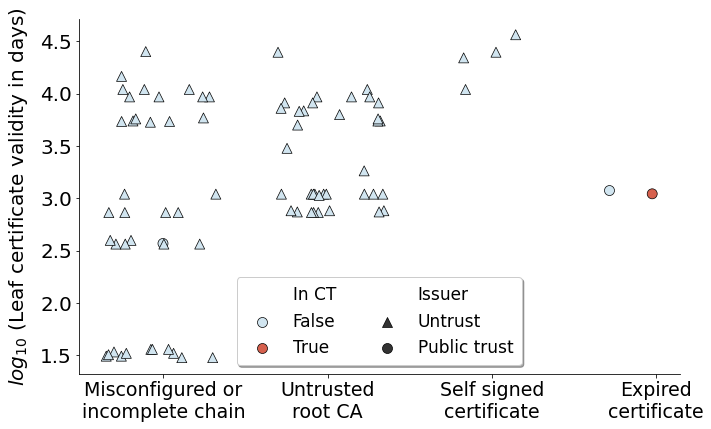

In [126]:
fig = plt.figure(figsize=(10,5.9))

ct_palette = ["#d1e5f0", "#d6604d"]
markers = {"Public trust": "o", "Untrust": "^"}

ax = sns.scatterplot(x="jittered", y="certday_log10", hue="In CT", style="Issuer", data=zeek_fig, \
                s=100, palette=ct_palette, markers=markers, alpha=1, linewidth=.7, edgecolor='black', x_jitter=True)

ax.set_xlabel('')
ax.set_ylabel("$log_{10}$ (Leaf certificate validity in days)", fontsize=20, labelpad=10)
plt.yticks(fontsize=20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles[0:], labels=labels[0:], title="",\
                   loc="lower center", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2,\
                   fontsize=17)
legend.get_frame().set_alpha(None)
for handle in legend.legendHandles:
    handle.set_sizes([100.0])
    handle.set_edgecolor('black')
    handle.set_linewidth(.7)
    handle.set_alpha(1)

plt.xticks([1,2,3,4], fontsize=15)
ax.set_xticklabels(["Misconfigured or\nincomplete chain", \
                    "Untrusted\nroot CA", \
                    "Self signed\ncertificate", \
                    "Expired\ncertificate"], \
                    fontsize=19)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.tight_layout()
plt.show()